## Preliminaries

In [1]:
!rm -rf *.sh

<br>

### Packages

In [2]:
%%bash

rm -rf explore
unzip -u -q explore.zip

rm -rf logs
mkdir logs

pip install yellowbrick==1.3.post1 &> logs/yellow.log
pip install pymc3==3.11.2 &> logs/pymc3.log
pip install cloudpickle==1.6.0 &> logs/cloudpickle.log
pip install dask[complete]==2.30.0 &> logs/dask.log

<br>

### Libraries

In [3]:
import logging
import collections

import os

import yellowbrick.cluster

import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.utils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<br>

### Logging

In [4]:
logging.basicConfig(level=logging.INFO, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>

### Custom

In [5]:
import config

import explore.graphics.relational
import explore.graphics.settings

import explore.functions.scalers

<br>

Configurations

In [6]:
configurations = config.Config()

<br>

Graphs

In [7]:
relational = explore.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [8]:
settings = explore.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>
<br>

## Data

### Reading

In [9]:
usecols = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 
           'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']

dtype = {'Area': np.int, 'Perimeter': np.float, 'MajorAxisLength': np.float, 'MinorAxisLength': np.float, 'AspectRation': np.float, 
         'Eccentricity': np.float, 'ConvexArea': np.int, 'EquivDiameter': np.float, 'Extent': np.float, 'Solidity': np.float, 
         'roundness': np.float, 'Compactness': np.float, 'ShapeFactor1': np.float, 'ShapeFactor2': np.float, 'ShapeFactor3': np.float, 
         'ShapeFactor4': np.float, 'Class': str}        

In [10]:
try:
    data = pd.read_csv(filepath_or_buffer='beans.csv', header=0, usecols=usecols, dtype=dtype, encoding='utf-8')
except OSError as err:
    raise Exception(err.strerror) in err

logger.info(data.info())

None
2021-05-19 13:29:11.482


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

<br>

### Renaming Fields

Rename each field to its lower case text

In [11]:
data.rename(str.lower, axis=1, inplace=True)
logger.info(data.info())

None
2021-05-19 13:29:11.520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             13611 non-null  int64  
 1   perimeter        13611 non-null  float64
 2   majoraxislength  13611 non-null  float64
 3   minoraxislength  13611 non-null  float64
 4   aspectration     13611 non-null  float64
 5   eccentricity     13611 non-null  float64
 6   convexarea       13611 non-null  int64  
 7   equivdiameter    13611 non-null  float64
 8   extent           13611 non-null  float64
 9   solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  compactness      13611 non-null  float64
 12  shapefactor1     13611 non-null  float64
 13  shapefactor2     13611 non-null  float64
 14  shapefactor3     13611 non-null  float64
 15  shapefactor4     13611 non-null  float64
 16  class            13611 non-null  object 
dtypes: float64(1

<br>

### Weights

In [12]:
classes = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

In [13]:
weight_values = sklearn.utils.class_weight.compute_class_weight(
    class_weight='balanced', classes=classes, y=data['class'])
weight_values

array([1.47082343, 3.72495895, 1.19290096, 0.54834421, 1.00852104,
       0.95926422, 0.73764362])

In [14]:
weights = dict(zip(classes, weight_values))
weights

{'BARBUNYA': 1.4708234277069376,
 'BOMBAY': 3.72495894909688,
 'CALI': 1.1929009640666082,
 'DERMASON': 0.548344210780759,
 'HOROZ': 1.0085210432720806,
 'SEKER': 0.9592642187610121,
 'SIRA': 0.7376436158681986}

<br>
<br>

## Observations

In [15]:
labels = ['class']

x_data = data.drop(columns=labels)
y_data = data[labels]

<br>

### Scaling

In [17]:
scalers = explore.functions.scalers.Scalers()
scaler = scalers.determine(blob=x_data)

x_scaled = scalers.apply(blob=x_data, scaler=scaler)

scaled = pd.concat((x_scaled, y_data), axis=1, ignore_index=False)

In [19]:
scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             13611 non-null  float64
 1   perimeter        13611 non-null  float64
 2   majoraxislength  13611 non-null  float64
 3   minoraxislength  13611 non-null  float64
 4   aspectration     13611 non-null  float64
 5   eccentricity     13611 non-null  float64
 6   convexarea       13611 non-null  float64
 7   equivdiameter    13611 non-null  float64
 8   extent           13611 non-null  float64
 9   solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  compactness      13611 non-null  float64
 12  shapefactor1     13611 non-null  float64
 13  shapefactor2     13611 non-null  float64
 14  shapefactor3     13611 non-null  float64
 15  shapefactor4     13611 non-null  float64
 16  class            13611 non-null  object 
dtypes: float64(1

<br>

### Encoding

In [20]:
CategoricalData = collections.namedtuple(
    typename='CategoricalData', field_names=['fields', 'arrays'])

fields = ['class']
arrays = [np.array(classes)]

categories = CategoricalData._make((fields, arrays))       

In [21]:
enc = sklearn.preprocessing.OneHotEncoder(categories=categories.arrays, sparse=False, dtype=np.int)
bits_ = enc.fit_transform(X=scaled[['class']])

columns = [column[(column.rindex('_') + 1):] for column in enc.get_feature_names()]
bits = pd.DataFrame(data=bits_, columns=columns)

encoded = pd.concat((scaled.drop(columns='class'), bits), axis=1, ignore_index=False)

<br>

### Elbow

Algorithm

In [23]:
kmc = sklearn.cluster.KMeans(random_state=5, max_iter=1000, algorithm='full')

<br>

Observations

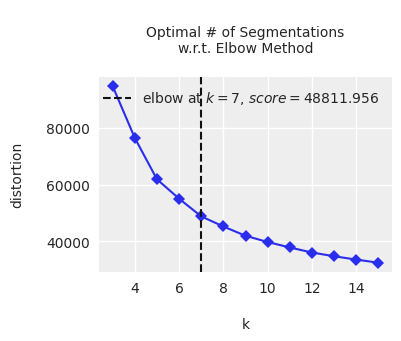

In [24]:
# Fit & Illustrate
ax = relational.figure(width=3.9, height=3.3)
ybc = yellowbrick.cluster.KElbowVisualizer(
    estimator=kmc, k=(3, 16), metric='distortion', timings=False, show=False, ax=ax,);
ybc.fit(X=scaled.drop(columns=labels))
relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nOptimal # of Segmentations\nw.r.t. Elbow Method\n', 
                                                        '\nk', 'distortion\n']))
ax.legend(loc='upper right', fontsize='small');


<br>
<br>

## Projecting

### t-SNE


* `ax.set_xticks(ticks=[-150, -100, -50, 0, 50, 100])`

Algorithm

In [25]:
sne = sklearn.manifold.TSNE(
    n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, 
    n_iter=1000, n_iter_without_progress=500, metric='cosine', init='pca', random_state=5, method='exact'
)

In [ ]:
transformation = sne.fit_transform(X=scaled.drop(columns=labels))

<br>

Projections


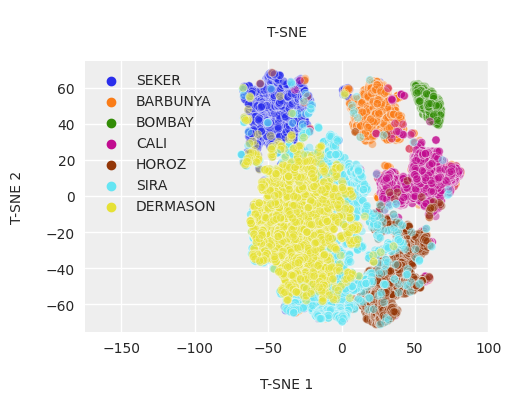

In [41]:
projections = pd.concat((pd.DataFrame(data=transformation, columns=['tsne_1', 'tsne_2']), scaled['class']), axis=1)

ax = relational.figure(width=5.0, height=3.9)
sns.scatterplot(data=projections, x='tsne_1', y='tsne_2', hue='class', alpha=0.45, ax=ax)

ax.set(xlim=(-175, 100), ylim=(-75, 75))

relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nT-SNE\n', 
                                                        '\nT-SNE 1', 'T-SNE 2\n']))
ax.legend(loc='upper left', fontsize='small'); 
    

<br>

### PCA

Algorithm

In [42]:
kpca_ = sklearn.decomposition.KernelPCA(kernel='cosine')

In [45]:
kpca = kpca_.fit(X=scaled.drop(columns=labels))

In [ ]:
principals = kpca.transform(scaled.drop(columns=labels))

<br>

Projections


Matrix Shape: (13611, 17), # of non-zero eigenvalues: 16
2021-05-19 15:44:34.803


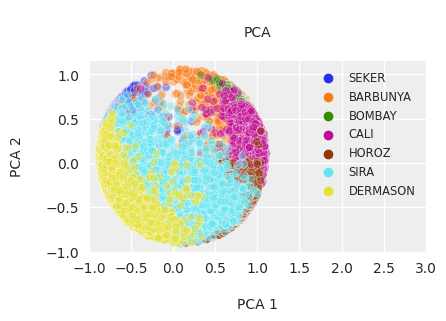

In [68]:
projections = pd.concat((pd.DataFrame(data=principals), scaled['class']), axis=1)
logger.info('\nMatrix Shape: {}, # of non-zero eigenvalues: {}'\
            .format(scaled.shape, kpca.lambdas_.shape[0]))

ax = relational.figure(width=4.35, height=3.1)
sns.scatterplot(data=projections, x=0, y=1, hue='class', alpha=0.45, ax=ax)

ax.set(xlim=(-1.0, 3.0), ylim=(-1.0, 1.15))

relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nPCA\n', '\nPCA 1', 'PCA 2\n']))
ax.legend(loc='upper right', fontsize='x-small'); 


In [69]:
kpca.lambdas_

array([6.96663082e+03, 2.96526045e+03, 1.43471111e+03, 1.08621598e+03,
       4.97762598e+02, 1.82024775e+02, 1.26326183e+02, 4.87558833e+01,
       5.51343165e+00, 8.99387374e-01, 7.19612244e-01, 2.04893039e-01,
       7.17480740e-02, 2.87790195e-03, 1.35381554e-03, 8.81177273e-04])